In [35]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

#클러스터링 관련 참조
from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

my_dpi=200

In [36]:
origin = load_data("game_usage")
origin.head()

[data] https://data.hossam.kr/ml-lab01/game_usage.xlsx
[desc] 게임 이용시간(time spent)과 레벨(game level)에 대한 가상 데이터
[!] Cannot read metadata


,time spent,game level
0,39,944
1,55,705
2,29,757
3,59,999
4,7,109


In [37]:
scaler = StandardScaler()
df1 = DataFrame(scaler.fit_transform(origin), columns = origin.columns)
df1.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


In [38]:
# 모델 객체 생성
estimator = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)

# 모델 학습
estimator.fit(df1)

#에측 ->predict() 메서드가 없음
cluster = estimator.labels_
cluster

array([ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  1,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0])

In [39]:
df2 = df1.copy()
df2["cluster"] = cluster
df2.head()

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,0
4,-1.405187,-1.558652,1


In [40]:
estimator.core_sample_indices_

array([ 1,  2,  4,  5,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 55, 57, 58, 60, 61, 62,
       63, 64, 65, 66, 68, 69, 70, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99])

In [41]:
df3 = df2.copy()

#기본적으로 모두 외곽 벡터로 지정
df3["vector"] = "border"

#핵심 벡터인 경우 "core"로 지정
df3.loc[estimator.core_sample_indices_, "vector"]="core"

#노이즈 분류
df3.loc[df3["cluster"]== -1, "vector"] = "noise"

df3.head()

,time spent,game level,cluster,vector
0,-0.250733,1.474805,0,border
1,0.326494,0.606546,0,core
2,-0.611500,0.795456,0,core
3,0.470801,1.674613,0,border
4,-1.405187,-1.558652,1,core


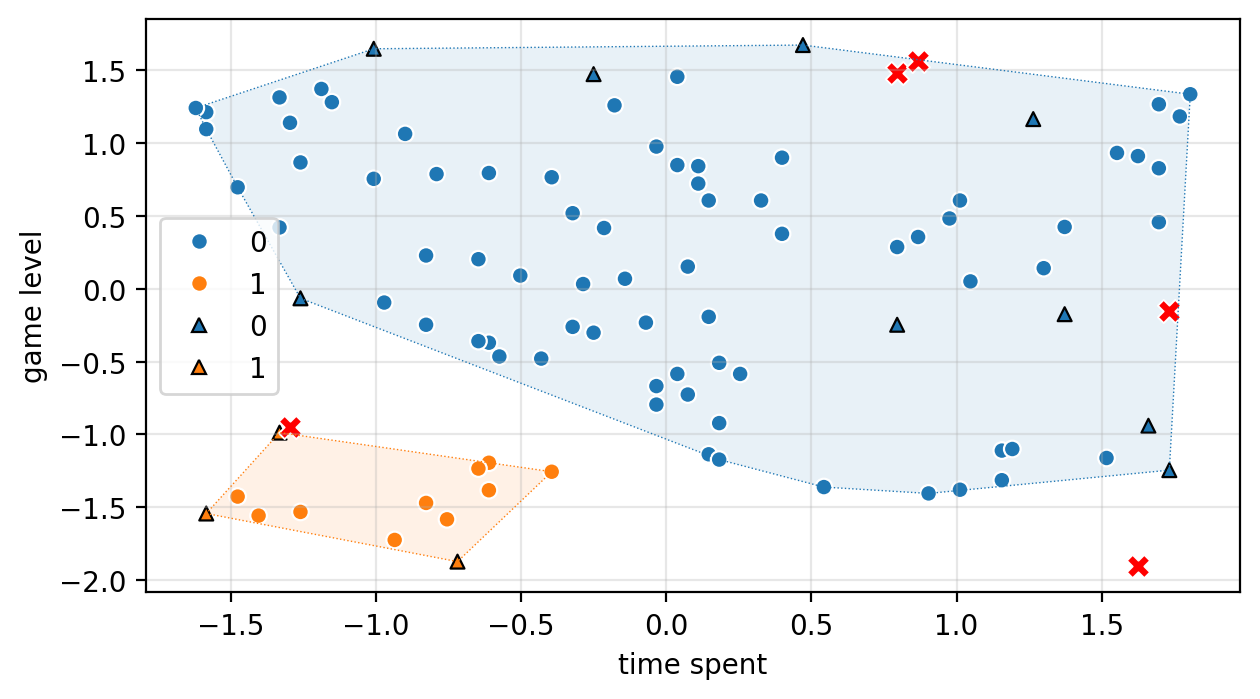

In [43]:
vdf = df3.copy()
hue_field = "cluster"
x_field = "time spent"
y_field = "game level"


figsize = (1280/ my_dpi,720/ my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi= my_dpi)


#군집별 값의 종류별로 반복
for c in vdf[hue_field].unique():
    #이상치는 건너뜀
    if c == -1:
        continue
    #값의 종류별로 데이터 프레임을 나눔
    df_c =vdf.loc[vdf[hue_field]==c, [x_field, y_field]]

    try:
        #외곽선 좌표 개산
        hull = ConvexHull(df_c)

        #마지막 좌효 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0])

        ax.plot( #type:ignore
            df_c.iloc[points, 0], df_c.iloc[points,1], linewidth=0.5, linestyle=":"
            )
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)

    except:
        pass

# 핵심 벡터만 표시
sb.scatterplot(
    data=vdf[(vdf[hue_field] !=-1) & (vdf["vector"] == "core")],
    x=x_field,
    y=y_field,
    hue="cluster",
    edgecolor="white",  #테두리색
    linewidth=0.8,     #테두리 두께
)

#외곽 벡터만 효시
sb.scatterplot(
    data=vdf[(vdf[hue_field] !=-1) & (vdf["vector"] == "border")],
    x=x_field,
    y=y_field,
    hue="cluster",
    marker="^",
    s=25,
    edgecolor="#000",  #테두리색
    linewidth=0.8,     #테두리 두께
)

#노이즈 벡터만 표시

sb.scatterplot(
    data=vdf[(vdf["vector"] == "noise")],
    x=x_field,
    y=y_field,
    color = "red",
    marker="X",
    s=70,
  
)

ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

군집의 결과로 설정된 label 값이 -1인 경우는 속한 집단이 없다고 해석해야 함.
해당 데이터 포인트가 잡음(Noise)로 분류되었음을 의미함.
DBSCAN은 밀도 기반 클러스터링 알고리즘으로, 데이터 포인트들 사이의 밀집도를 기준으로 클러스터를 형성하는데
이 과정에서 일정 밀도 이상의 데이터 포인트들은 클러스터에 포함되지만, 그 기준을 만족하지 못하는 데이터 포인트 들은 잡음으로 분류된다.

잡음으로 분류된 노이즈 데이터는 이상치로 해석할 수 있다.
이를 해결하기 위해
1.이상치 정제후 다시 수행하거나
2.eps와 minPts 파라미터를 조정하여
클러스터링 결과를 개선해야 한다.